# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
print("Python %s" % sys.version)

Python 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [2]:
import gym
print("OpenAI Gym %s" % gym.__version__)

OpenAI Gym 0.14.0


In [3]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.4


In [4]:
import matplotlib
print("matplotlib %s" % matplotlib.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

matplotlib 2.2.2


In [5]:
import time
from collections import defaultdict, deque

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [6]:
env = gym.make('CliffWalking-v0')

In [7]:
env

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [8]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

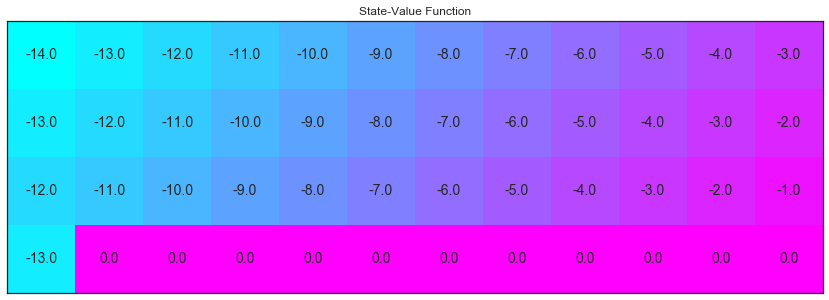

In [9]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(*Feel free to define additional functions to help you to organize your code.*)

Epsilon-greedy policies.`[1]`
![function-epsilon-greedy](./images/function-epsilon-greedy.png)

In [10]:
def generate_policy_from_epsilon_greedy(Q, epsilon, state):
    num_actions = len(Q[state])
    # else
    policy = np.ones(num_actions) * (epsilon / num_actions)
    # if a maximizes Q(s,a)
    max_action = np.argmax(Q[state])
    policy[max_action] += (1 - epsilon)
    
    return policy

In [11]:
def generate_action_from_policy(policy):
    num_actions = len(policy)
    max_q = float(sum(policy))
    probs = [q / max_q for q in policy]
    action = np.random.choice(np.arange(num_actions), p=probs)

    return action

In [12]:
def generate_action_from_epsilon_greedy(Q, epsilon, state):
    policy = generate_policy_from_epsilon_greedy(Q, epsilon, state)
    action = generate_action_from_policy(policy)
    
    return action

The algorithm for Sarsa.`[2]`
![algo-sarsa](./images/algo-sarsa.png)

In [24]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        epsilon = 1.0 / i_episode
        # observe S_0
        state = env.reset()
        # choose action A_0 using policy derived from Q-table
        action = generate_action_from_epsilon_greedy(Q, epsilon, state)
        while(True):
            # take action A_t and observe R_t+1, S_t+1
            next_state, reward, done, info = env.step(action)
            # choose action A_t+1 using policy derived from Q-table
            next_action = generate_action_from_epsilon_greedy(Q, epsilon, next_state)
            # update Q-table
            Q[state][action] += alpha * (reward + 
                                         (gamma * Q[next_state][next_action]) - 
                                         Q[state][action])
            # S_t <- S_t+1 and A_t <- A_t+1
            state = next_state
            action = next_action
            # S_t is terminal
            if done:
                break

    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

Runtime 6 seconds


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  3  1  1  2  2  1  1  3  1  3  2]
 [ 1  0  1  1  2  1  2  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


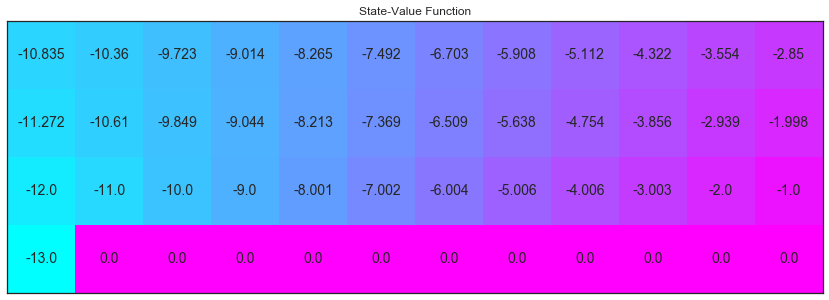

In [25]:
# obtain the estimated optimal policy and corresponding action-value function
num_episodes = 5000 # 5000
tic = time.time()
Q_sarsa = sarsa(env, num_episodes, alpha=.01)
toc = time.time()
print('\n\nRuntime %d seconds' % int(toc-tic))

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) \
                         if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(*Feel free to define additional functions to help you to organize your code.*)

The algorithm for Sarsamax (Q-Learning).`[2]`
![algo-sarsamax-q-learning](./images/algo-sarsamax-q-learning.png)

In [29]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        epsilon = 1.0 / i_episode
        # observe S_0 
        state = env.reset()
        while(True):
            # choose action A_t using policy derived from Q-table
            action = generate_action_from_epsilon_greedy(Q, epsilon, state)
            # take action A_t and observe R_t+1, S_t+1
            next_state, reward, done, info = env.step(action)
            # update Q-table
            Q[state][action] += alpha * (reward + 
                                         (gamma * max(Q[next_state])) - 
                                         Q[state][action])
            # S_t <- S_t+1
            state = next_state
            # S_t is terminal
            if done:
                break

    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

Runtime 6 seconds


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  0  3  2  1  1  2  3  1  2  0]
 [ 1  0  2  3  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


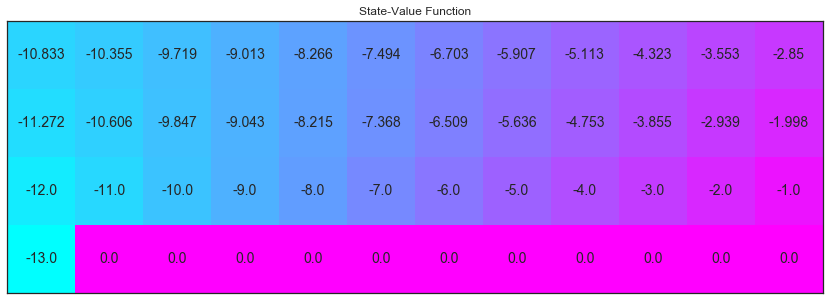

In [19]:
# obtain the estimated optimal policy and corresponding action-value function
num_episodes = 5000 # 5000
tic = time.time()
Q_sarsamax = q_learning(env, num_episodes, .01)
toc = time.time()
print('\n\nRuntime %d seconds' % int(toc-tic))

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(*Feel free to define additional functions to help you to organize your code.*)

The algorithm for Expected Sarsa.`[2]`
![algo-expected-sarsa](./images/algo-expected-sarsa.png)

In [60]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        epsilon = 0.005 # 1.0 / i_episode
        # observe S_0 
        state = env.reset()
        while(True):
            # choose action A_t using policy derived from Q-table
            action = generate_action_from_epsilon_greedy(Q, epsilon, state)
            # take action A_t and observe R_t+1, S_t+1
            next_state, reward, done, info = env.step(action)
            # update Q-table
            policy = generate_policy_from_epsilon_greedy(Q, epsilon, next_state)
            Q[state][action] += alpha * (reward + 
                                         (gamma * np.dot(policy, Q[next_state])) - 
                                         Q[state][action])
            # S_t <- S_t+1
            state = next_state
            # S_t is terminal
            if done:
                break
            
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

Runtime 6 seconds


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  1  2  0  1  1  1  3  1  2]
 [ 3  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


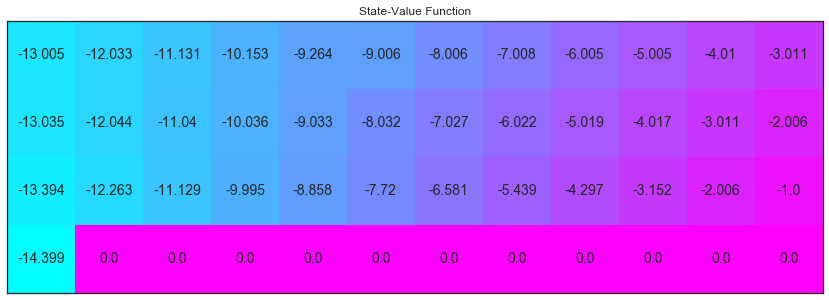

In [61]:
# obtain the estimated optimal policy and corresponding action-value function
num_episodes = 5000 # 10000
tic = time.time()
Q_expsarsa = expected_sarsa(env, num_episodes, 1)
toc = time.time()
print('\n\nRuntime %d seconds' % int(toc-tic))

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

### References

`[1]` Udacity. *Epsilon-Greedy Policies*. Deep Reinforcement Learning for Enterprise Nanodegree Program, Part 1, Lesson 6. 2019.

`[2]` Udacity. *Reinforcement Learning Cheatsheet*. Deep Reinforcement Learning for Enterprise Nanodegree Program. 2019. https://github.com/udacity/deep-reinforcement-learning/blob/master/cheatsheet/cheatsheet.pdf